In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## ID particulas a z = 0 Gasoline

In [3]:
import pynbody

path = '/srv/cosmdatc/clues/B64_WM3_186592/LG/GAS_SFR/4096_Gasoline/'
s = pynbody.load(path + '1024/WMAP3.CLUES.HR.001024')
h = s.halos()


In [14]:
vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram/_data/'

for i in range(0,3):
    h1 = h[vector[i]]

    r200  = h1.properties['Rvir']
    IDs   = h1.star['iord']
    tform = h1.star['tform'].in_units('Gyr')

    cen_pot = pynbody.analysis.halo.center(h1,mode='pot',retcen=True).in_units('kpc')

    rgal = 0.15*r200

    xstr=((h1.star['pos'].in_units('kpc'))[:,0] - cen_pot[0])
    ystr=((h1.star['pos'].in_units('kpc'))[:,1] - cen_pot[1])
    zstr=((h1.star['pos'].in_units('kpc'))[:,2] - cen_pot[2])
     
    rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)    
    
    limit, = np.where(rstr<rgal)
    
    rn = rstr[limit]
    ID = IDs[limit]
    tf = tform[limit]

    data = np.zeros([len(rn),3])
    data[:,0]= ID
    data[:,1]= rn
    data[:,2]= tf


    np.savetxt(path2 + str('%s'%vector2[i])+'_tform_z0.dat', data, 
               fmt=('%15d','%12.6f','%12.6f'))

## Distancias de las particulas en tform

In [20]:
from joblib import Parallel, delayed

#------------------------------------------------------------------------
vector2 = ('M31', 'MW', 'M33')

path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram/_data/'

path = '/srv/cosmdatc/clues/B64_WM3_186592/LG/GAS_SFR/4096_Gasoline/'


for l in range(0,3):
    
    file = np.loadtxt(path2 + str('%s'%vector2[l]) +'_tform_z0.dat')
    ID    = file[:,0]
    tform = file[:,2]
    
    sort = np.argsort(tform)
    
    sort_tform = tform[sort][::-1]
    sort_ID    = ID[sort][::-1]
    
    file2 = np.loadtxt(path2 +  str('%s'%vector2[l]) +'_masscenter.dat')
    time = file2[:,0]
    xcm  = file2[:,1]
    ycm  = file2[:,2]
    zcm  = file2[:,3]
    
    
    time_aux = np.zeros(len(ID))

    k = 1
    for i in range(0,len(ID)):
        for j in range(k, len(time)):
            if sort_tform[i] > time[j]:
                time_aux[i] = time[j-1]
    #             print time_aux[i]
                if time_aux[i] < time_aux[i-1]:
                    k = k + 1
                break

    snapshot = np.loadtxt('/z/omarioni/snapshots.txt', dtype='string') #SNAPSHOTS
    isnap = snapshot[::-1]
    
    archivo = open(path2 + str('%s'%vector2[l]) + '_tform_particles.dat', 'a')

    for i in range(0, len(time)):

        mask, = np.where(time_aux == time[i])

        if len(mask) == 0:
            break

        s = pynbody.load(path + str('%s'%isnap[i])+'/WMAP3.CLUES.HR.00'+ str('%s'%isnap[i]))

        IDs = s.star['iord']
        
        pstr = s.star['pos'].in_units('kpc')
        IDs  = s.star['iord']
        tf   = s.star['tform'].in_units('Gyr')

        particles = np.isin(IDs, sort_ID[mask])

        xstr = (pstr[:,0][particles]-xcm[i])
        ystr = (pstr[:,1][particles]-ycm[i])
        zstr = (pstr[:,2][particles]-zcm[i])

        rstr = np.sqrt(xstr**2 + ystr**2 + zstr**2)

        data = np.ndarray([len(mask), 3])
        data[:,0] = IDs[particles]
        data[:,1] = rstr
        data[:,2] = tf[particles]
        
        np.savetxt(archivo, data, fmt=('%15d','%12.6f','%12.6f'))
        
    archivo.close()

            


In [ ]:
with Parallel(n_jobs=3, prefer="threads") as par:
    par(delayed(sarasa)(ll)for ll in range(0,3))

In [2]:
path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram/_data/'

M31gs = np.loadtxt(path2 + 'M31_tform_particles.dat')
ID_M31 = M31gs[:,0]
r_M31  = M31gs[:,1]
tf_M31 = M31gs[:,2]

# M31gs = np.loadtxt(path2 + 'M31_part_barra.dat')
# Ids  = M31gs[:,0]


# mask = np.isin(ID_M31, Ids)

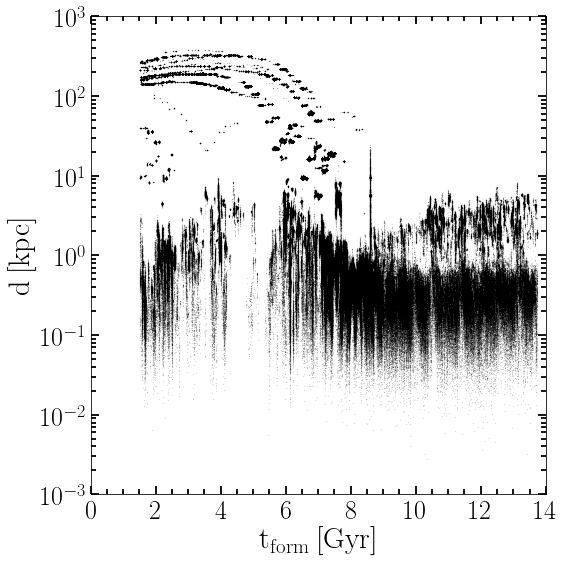

In [8]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(tf_M31 ,r_M31,'.k', markersize=0.1)
# ax.plot(tf_M31[mask] ,r_M31[mask],'.r', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
ax.set_ylim(10**-3,10**3)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()

In [4]:
path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram/_data/'

MWgs = np.loadtxt(path2 + 'MW_tform_particles.dat')
ID_MW = MWgs[:,0]
r_MW  = MWgs[:,1]
tf_MW = MWgs[:,2]

# M31gs = np.loadtxt(path2 + 'M31_part_barra.dat')
# Ids  = M31gs[:,0]


# mask = np.isin(ID_M31, Ids)

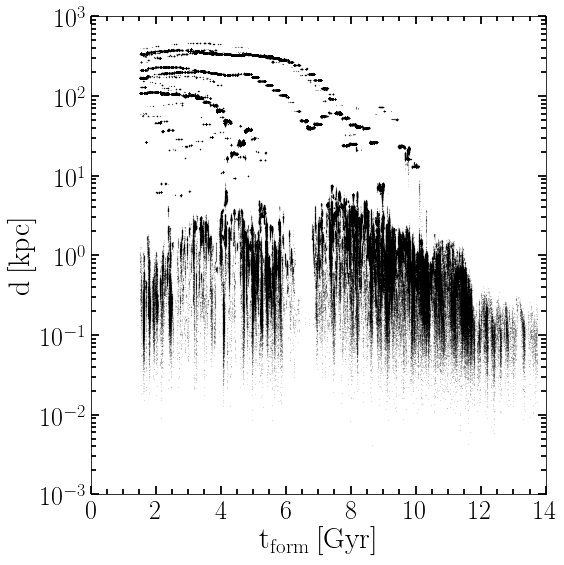

In [9]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(tf_MW ,r_MW,'.k', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
ax.set_ylim(10**-3,10**3)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()

In [6]:
path2 = '/z/omarioni/Barras_GdGs/erebos/pyprogram/_data/'

M33gs = np.loadtxt(path2 + 'M33_tform_particles.dat')
ID_M33 = M33gs[:,0]
r_M33  = M33gs[:,1]
tf_M33 = M33gs[:,2]

# M31gs = np.loadtxt(path2 + 'M31_part_barra.dat')
# Ids  = M31gs[:,0]


# mask = np.isin(ID_M31, Ids)

In [30]:
print len(ID_M33)

267820


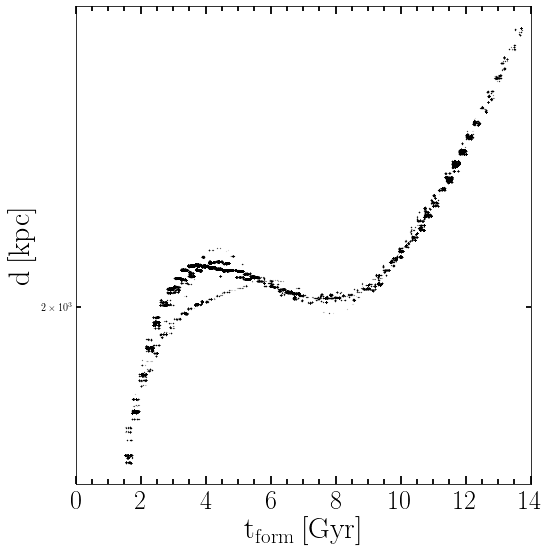

In [19]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(tf_M33 ,r_M33,'.k', markersize=0.1)
# ax.plot(tf_M33[mask] ,r_M31[mask],'.r', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
# ax.set_ylim(10**3,30**3)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()

In [12]:
file = np.loadtxt(path2 + 'M33_tform_z0.dat')
ID    = file[:,0]
rz0   = file[:,1]
tform = file[:,2]

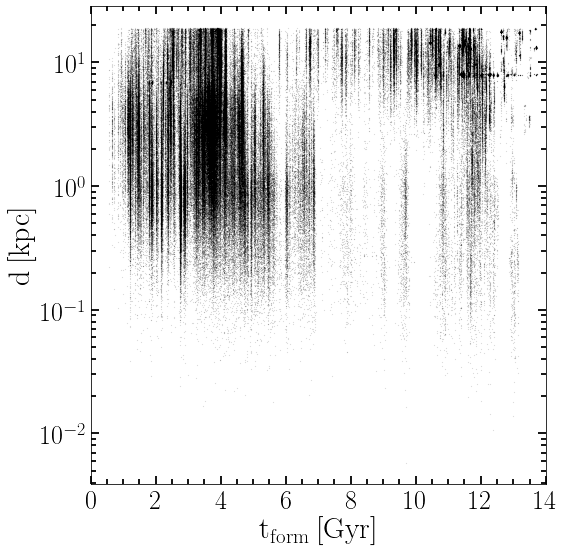

In [15]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

ax.plot(tform ,rz0,'.k', markersize=0.1)
# ax.plot(tf_M33[mask] ,r_M31[mask],'.r', markersize=0.1)
ax.set_yscale('log')
ax.set_ylabel(r'$\mathrm{d\:[kpc]}$', fontsize=30)
ax.set_xlabel(r'$\mathrm{t_{form}\:[Gyr]}$',fontsize=30)
ax.set_xticks(range(0,15,2))
# ax.set_ylim(10**-3,30**3)
ax.set_xlim(0,14)
ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2max_time.pdf', dpi = 100, xxbox_inches='tight')


plt.show()